<a href="https://colab.research.google.com/github/CapstoneGrp9199/code/blob/main/Initial_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Draft project - Code

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from scipy.optimize import minimize
import seaborn as sns

In [ ]:
pip install yfinance numpy pandas gym torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  12 of 12 completed



Summary Statistics of Daily Returns:
Ticker         AAPL         ASML           BA         GOOG          JNJ  \
count   2263.000000  2263.000000  2263.000000  2263.000000  2263.000000   
mean       0.001079     0.001156     0.000699     0.000906     0.000354   
std        0.018293     0.022458     0.025762     0.018012     0.011560   
min       -0.128647    -0.173492    -0.238484    -0.111008    -0.100379   
25%       -0.007450    -0.010299    -0.009630    -0.007050    -0.004929   
50%        0.000897     0.001409     0.000527     0.000919     0.000299   
75%        0.010217     0.013164     0.010939     0.009357     0.006000   
max        0.119808     0.145732     0.243186     0.160524     0.079977   

Ticker          JPM           KO          MCD         MSFT           PG  \
count   2263.000000  2263.000000  2263.000000  2263.000000  2263.000000   
mean       0.000704     0.000342     0.000698     0.001139     0.000397   
std        0.017493     0.011503     0.013032     0.017529   

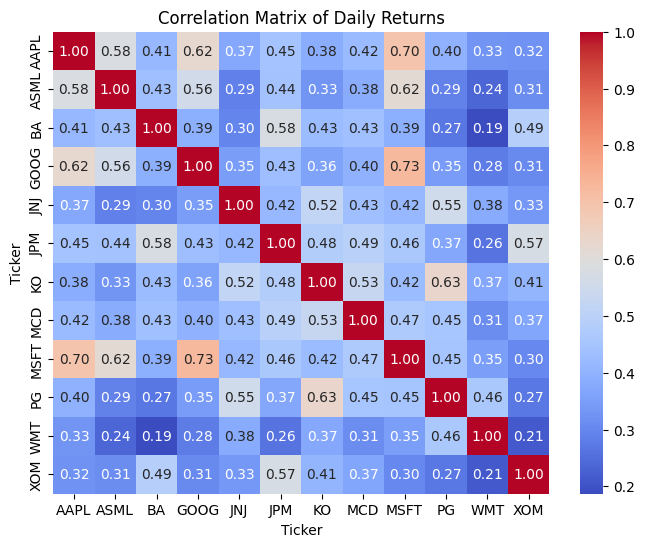

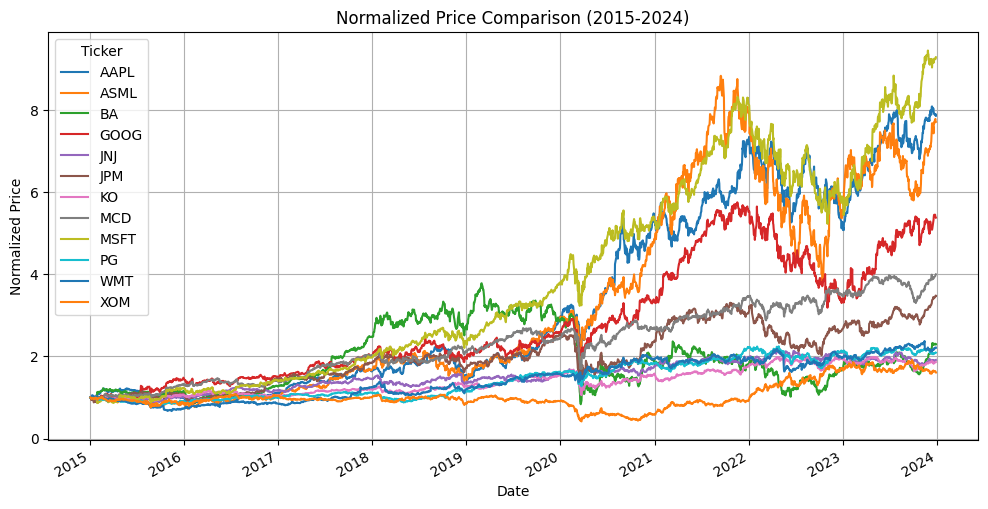

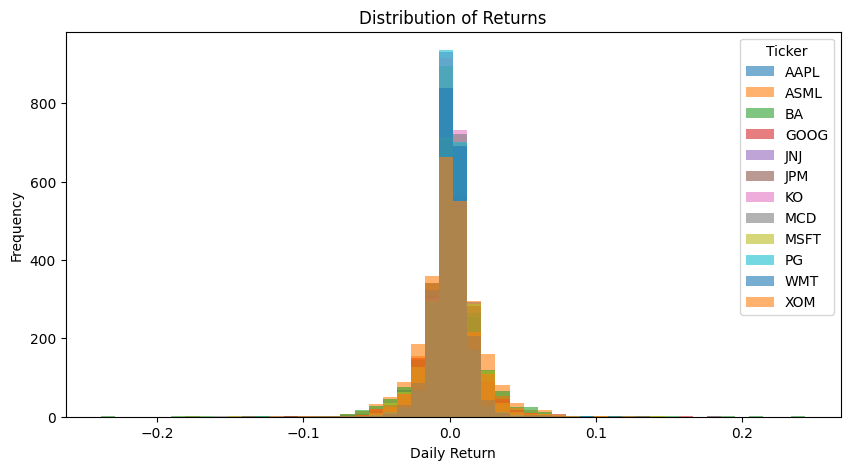

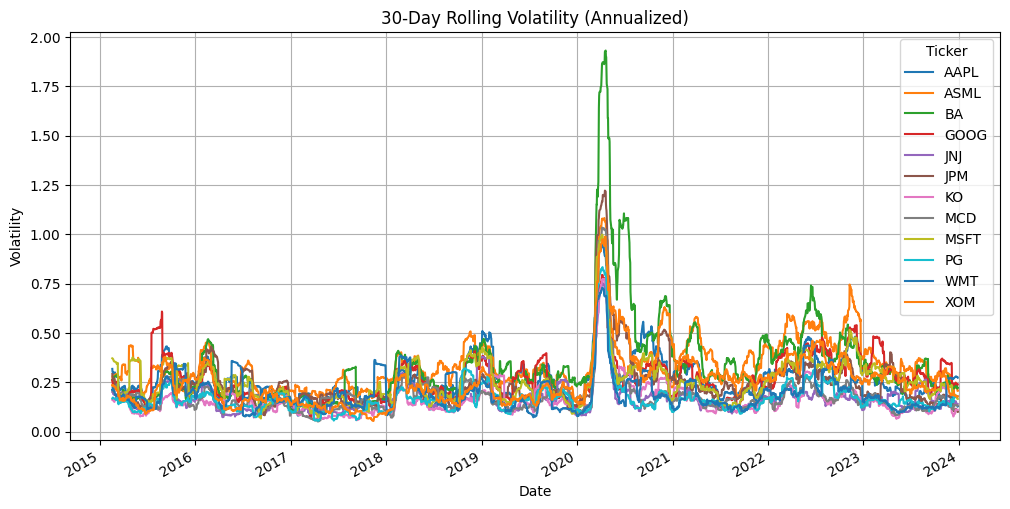

In [ ]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'KO', 'JNJ', 'JPM', 'WMT', 'MCD', 'PG', 'BA', 'XOM','ASML']
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2024, 1, 1)

price_data = yf.download(tickers, start=start, end=end)['Close']
returns = price_data.pct_change().dropna()

print("\nSummary Statistics of Daily Returns:")
print(returns.describe())

plt.figure(figsize=(8, 6))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Daily Returns")
plt.show()

normalized_prices = price_data / price_data.iloc[0]
normalized_prices.plot(figsize=(12, 6), title="Normalized Price Comparison (2015-2024)")
plt.ylabel("Normalized Price")
plt.xlabel("Date")
plt.grid(True)
plt.show()

returns.plot(kind='hist', bins=50, alpha=0.6, figsize=(10, 5), title="Distribution of Returns")
plt.xlabel("Daily Return")
plt.show()

rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)  # Annualized 30-day volatility
rolling_vol.plot(figsize=(12, 6), title="30-Day Rolling Volatility (Annualized)")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(returns)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  12 of 12 completed



Summary Statistics of Daily Returns:
Ticker         AAPL         ASML           BA         GOOG          JNJ  \
count   2263.000000  2263.000000  2263.000000  2263.000000  2263.000000   
mean       0.001079     0.001156     0.000699     0.000906     0.000354   
std        0.018293     0.022458     0.025762     0.018012     0.011560   
min       -0.128647    -0.173491    -0.238484    -0.111008    -0.100379   
25%       -0.007450    -0.010299    -0.009630    -0.007050    -0.004929   
50%        0.000897     0.001409     0.000526     0.000919     0.000299   
75%        0.010217     0.013164     0.010939     0.009357     0.006000   
max        0.119808     0.145732     0.243186     0.160524     0.079977   

Ticker          JPM           KO          MCD         MSFT           PG  \
count   2263.000000  2263.000000  2263.000000  2263.000000  2263.000000   
mean       0.000704     0.000342     0.000698     0.001139     0.000397   
std        0.017493     0.011503     0.013032     0.017529   

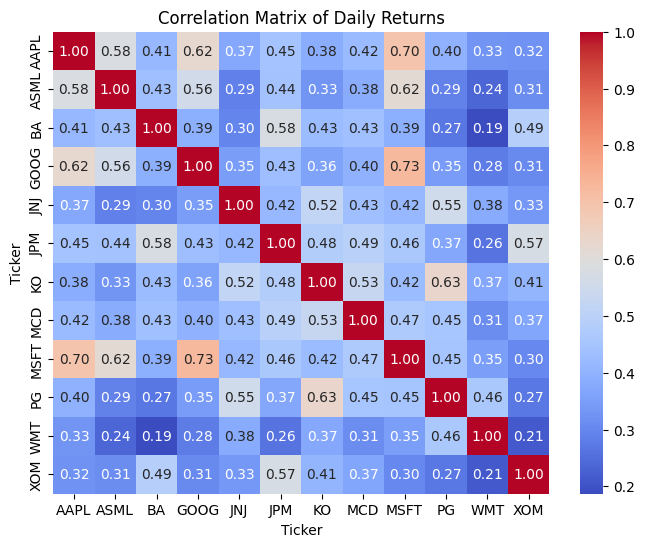

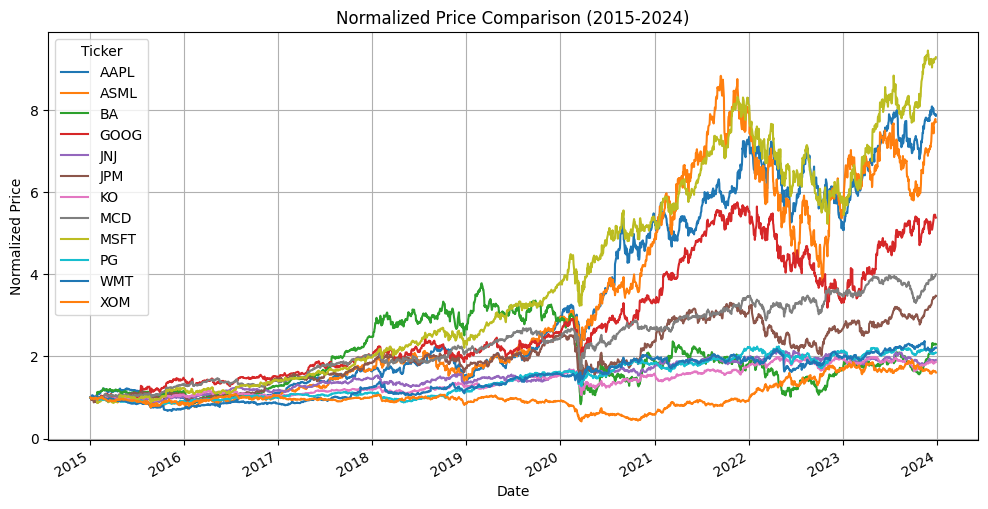

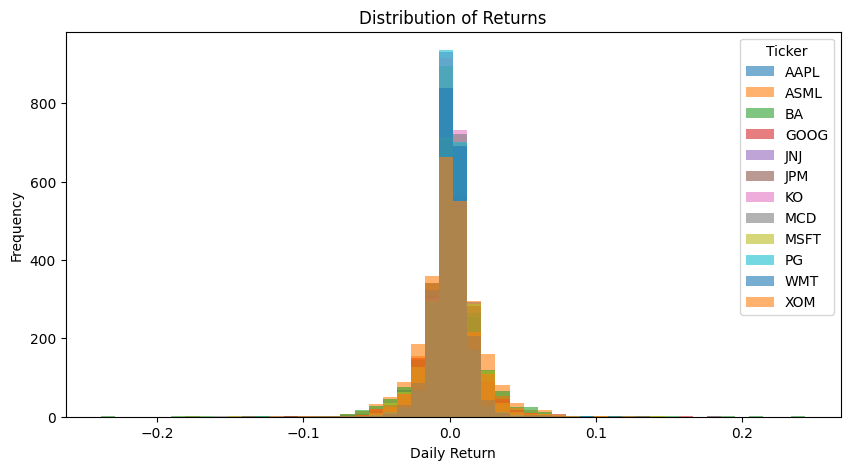

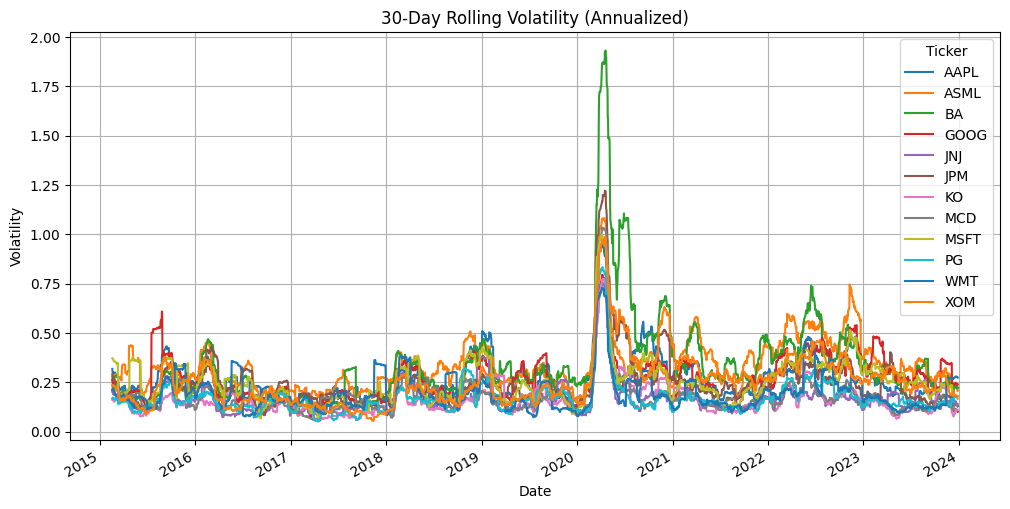

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0817
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0042
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0041
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0041
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0038
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0039
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0043
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0038
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0039
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [ ]:
def create_sequences(data, window_size):
    x, y = [], []
    for i in range(len(data) - window_size):
        x.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(x), np.array(y)

window_size = 20
x_lstm, y_lstm = create_sequences(scaled_data, window_size)

lstm_model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(x_lstm.shape[1], x_lstm.shape[2])),
    Dense(y_lstm.shape[1])
])
lstm_model.compile(loss='mse', optimizer='adam')
lstm_model.fit(x_lstm, y_lstm, epochs=10, batch_size=32, verbose=1)

predicted_returns = lstm_model.predict(x_lstm)


LSTM + Mean-Variance Optimal Weights:
AAPL: 0.0000
MSFT: 0.0000
GOOG: 0.0000
KO: 0.0000
JNJ: 0.6103
JPM: 0.0000
WMT: 0.0000
MCD: 0.0000
PG: 0.3897
BA: 0.0000
XOM: 0.0000
ASML: 0.0000

LSTM-Only Portfolio Weights:
AAPL: 0.0000
MSFT: 0.1298
GOOG: 0.0000
KO: 0.1280
JNJ: 0.2176
JPM: 0.0000
WMT: 0.0000
MCD: 0.0759
PG: 0.3269
BA: 0.1219
XOM: 0.0000
ASML: 0.0000

Mean-Variance Optimal Weights (Historical):
AAPL: 0.0000
MSFT: 0.0000
GOOG: 0.0000
KO: 0.0285
JNJ: 0.2547
JPM: 0.0000
WMT: 0.1934
MCD: 0.1481
PG: 0.0000
BA: 0.1291
XOM: 0.1927
ASML: 0.0535

Mean of all optimized weight models:
AAPL: 0.0000
MSFT: 0.0000
GOOG: 0.0000
KO: 0.0285
JNJ: 0.2547
JPM: 0.0000
WMT: 0.1934
MCD: 0.1481
PG: 0.0000
BA: 0.1291
XOM: 0.1927
ASML: 0.0535


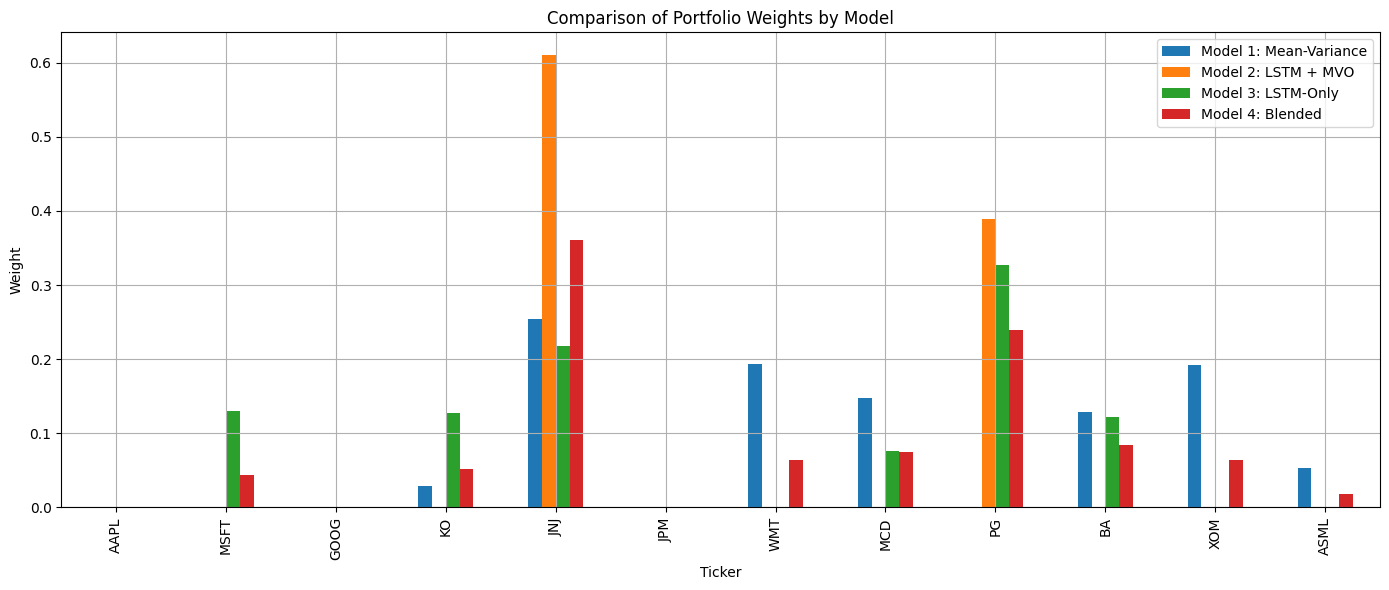

In [ ]:
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler

def negative_sharpe_ratio(weights, predicted_returns, cov_matrix):

    portfolio_return = np.dot(weights, predicted_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    if portfolio_volatility == 0:
        return np.inf
    return -portfolio_return / portfolio_volatility

def optimize_portfolio(predicted_returns, cov_matrix):

    n_assets = len(predicted_returns)
    initial_weights = np.full(n_assets, 1.0 / n_assets)
    bounds = [(0, 1)] * n_assets
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    result = minimize(
        fun=negative_sharpe_ratio,
        x0=initial_weights,
        args=(predicted_returns, cov_matrix),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result.x if result.success else None

# inputs
latest_predicted_returns = scaler.inverse_transform([predicted_returns[-1]])[0]  # Unscaled predicted returns
annualized_cov_matrix = returns.cov().values * 252  # Annualized covariance


# Run optimization
optimal_weights = optimize_portfolio(latest_predicted_returns, annualized_cov_matrix)

# Display results
if optimal_weights is not None:
    print("\nLSTM + Mean-Variance Optimal Weights:")
    for ticker, weight in zip(tickers, optimal_weights):
        print(f"{ticker}: {weight:.4f}")
else:
    print("Optimization failed.")


# --- LSTM Portfolio Optimization ---
def lstm_only_weights(predicted_ret):
    # Ensure no negative weights (or handle differently if short-selling is allowed)
    predicted_ret = np.maximum(predicted_ret, 0)
    total = np.sum(predicted_ret)
    if total == 0:
        return np.full_like(predicted_ret, 1. / len(predicted_ret))
    return predicted_ret / total  # Normalize to sum to 1

# Unscale the last predicted returns from the LSTM
latest_predicted_ret = scaler.inverse_transform([predicted_returns[-1]])[0]  # shape: (n_assets,)

# Compute weights using LSTM-only
lstm_weights = lstm_only_weights(latest_predicted_ret)

print("\nLSTM-Only Portfolio Weights:")
for t, w in zip(tickers, lstm_weights):
    print(f"{t}: {w:.4f}")
# --- Classical Mean-Variance Optimization ---
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def min_variance_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(portfolio_volatility, num_assets * [1. / num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

mv_weights = min_variance_portfolio(mean_returns, cov_matrix)
print("\nMean-Variance Optimal Weights (Historical):")
for t, w in zip(tickers, mv_weights):
    print(f"{t}: {w:.4f}")


Mean_optimized_weights = (lstm_weights + optimal_weights + mv_weights) / 3
print("\nMean of all optimized weight models:")
for t, w in zip(tickers, mv_weights):
    print(f"{t}: {w:.4f}")

weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Model 1: Mean-Variance': mv_weights,
    'Model 2: LSTM + MVO': optimal_weights,
    'Model 3: LSTM-Only': lstm_weights,
    'Model 4: Blended': Mean_optimized_weights
})
weights_df.set_index('Ticker', inplace=True)
weights_df = weights_df.round(4)
weights_df.plot(kind='bar', figsize=(14, 6), title='Comparison of Portfolio Weights by Model')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

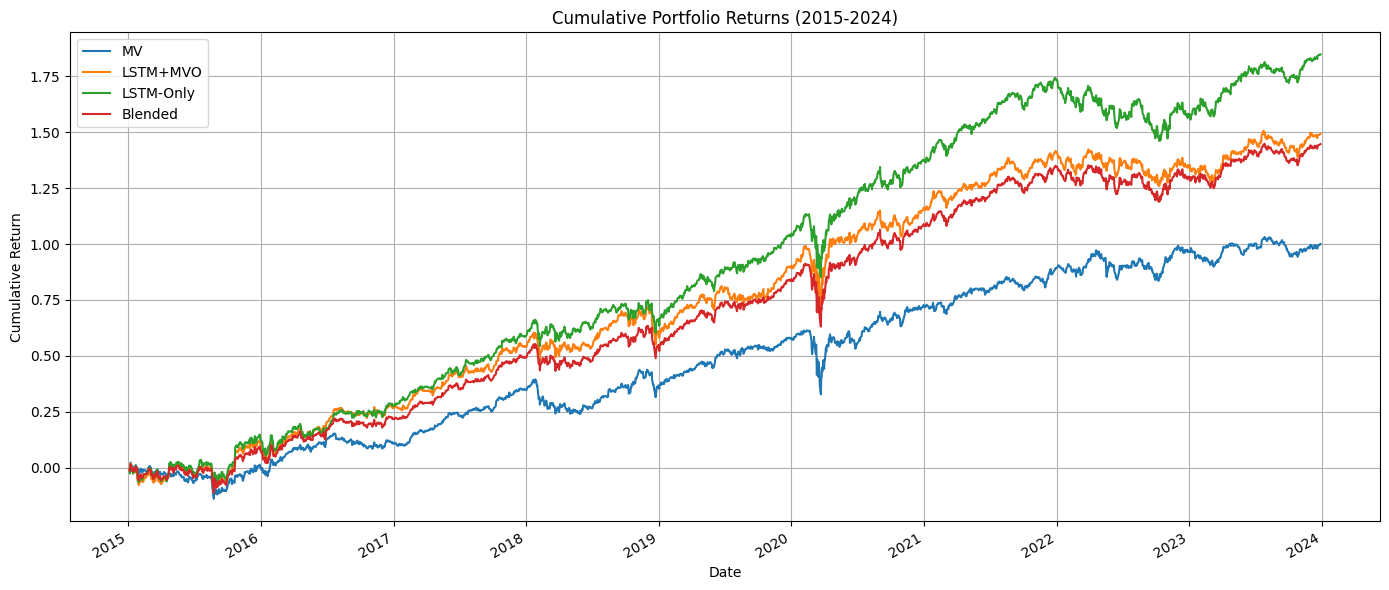

Performance Metrics Comparison:


,Annualized Return,Annualized Volatility,Sharpe Ratio
MV,0.1114,0.1455,0.0439
LSTM+MVO,0.1663,0.1855,0.0531
LSTM-Only,0.2058,0.1960,0.0629
Blended,0.1612,0.1663,0.0572


In [ ]:
# --- Backtesting Portfolios ---
def backtest_portfolio(weights, returns):
    return (returns @ weights).to_frame(name='Daily Return')

results = {
    'MV': backtest_portfolio(mv_weights, returns),
    'LSTM+MVO': backtest_portfolio(optimal_weights, returns),
    'LSTM-Only': backtest_portfolio(lstm_weights, returns),
    'Blended': backtest_portfolio(Mean_optimized_weights, returns)
}

cumulative_returns = pd.concat([df.cumsum() for df in results.values()], axis=1)
cumulative_returns.columns = results.keys()
cumulative_returns.plot(figsize=(14, 6), title='Cumulative Portfolio Returns (2015-2024)')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Sharpe Ratios & Volatility ---
performance_metrics = {}
risk_free_rate = 0.01 / 252  # Approximate daily risk-free rate

for model, df in results.items():
    mean_ret = df.mean().values[0]
    std_ret = df.std().values[0]
    sharpe = (mean_ret - risk_free_rate) / std_ret
    volatility = std_ret * np.sqrt(252)
    performance_metrics[model] = {
        'Annualized Return': mean_ret * 252,
        'Annualized Volatility': volatility,
        'Sharpe Ratio': sharpe
    }

metrics_df = pd.DataFrame(performance_metrics).T.round(4)
print("Performance Metrics Comparison:")
display(metrics_df)


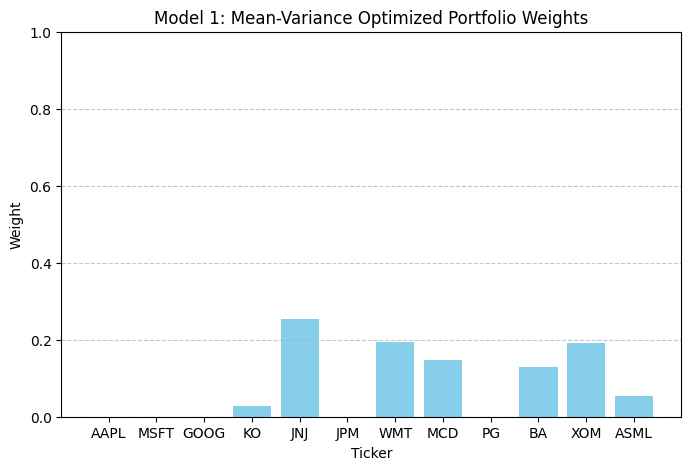

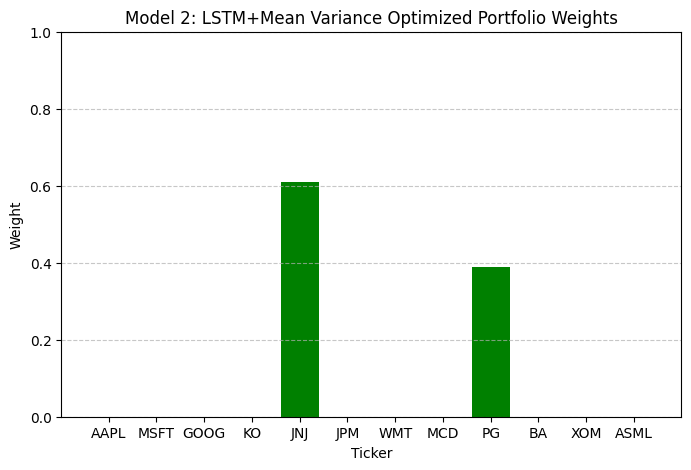

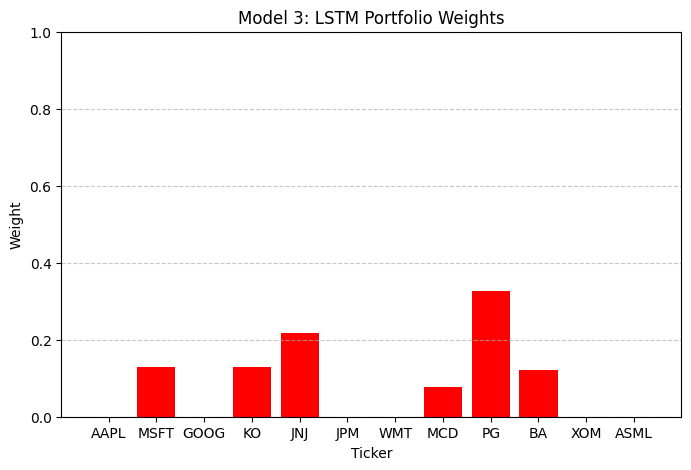

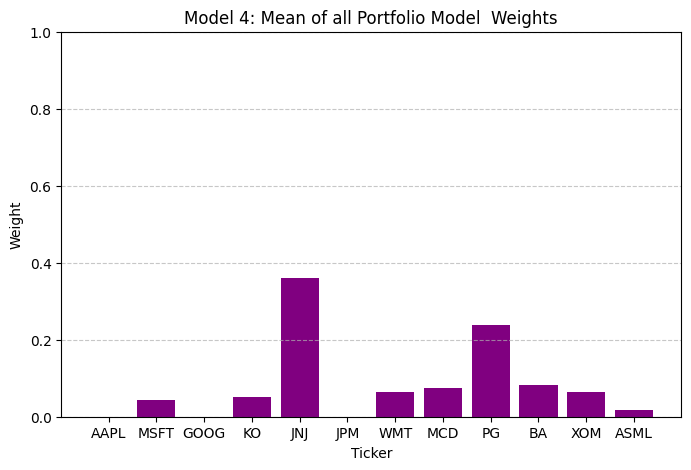

In [ ]:
# ----plot----- #
plt.figure(figsize=(8, 5))
plt.bar(tickers, mv_weights, color='skyblue')
plt.title('Model 1: Mean-Variance Optimized Portfolio Weights')
plt.xlabel('Ticker')
plt.ylabel('Weight')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


plt.figure(figsize=(8, 5))
plt.bar(tickers,optimal_weights, color='green')
plt.title('Model 2: LSTM+Mean Variance Optimized Portfolio Weights')
plt.xlabel('Ticker')
plt.ylabel('Weight')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(tickers,lstm_weights, color='Red')
plt.title('Model 3: LSTM Portfolio Weights')
plt.xlabel('Ticker')
plt.ylabel('Weight')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(tickers,Mean_optimized_weights, color='Purple')
plt.title('Model 4: Mean of all Portfolio Model  Weights')
plt.xlabel('Ticker')
plt.ylabel('Weight')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from arch.bootstrap import StationaryBootstrap

# weights defined before
mv_weights = np.array(mv_weights)
lstm_weights = np.array(lstm_weights)
lstm_mvo_weights = np.array(optimal_weights)

# daily returns of each strategy
mv_returns = returns.dot(mv_weights)
lstm_returns = returns.dot(lstm_weights)
lstm_mvo_returns = returns.dot(lstm_mvo_weights)

# output
print("Backtested Daily Portfolio Returns:")
print(pd.DataFrame({
    'MV': mv_returns,
    'LSTM': lstm_returns,
    'LSTM+MVO': lstm_mvo_returns
}).head())

# Step 1: Compute 'loss' as negative returns
loss_mv = -mv_returns.values
loss_lstm = -lstm_returns.values
loss_lstm_mvo = -lstm_mvo_returns.values

# Step 2: Setup Stationary Bootstrap
bs = StationaryBootstrap(10, loss_mv)  # block size of 10

# Step 3: DM test function
def dm_test(loss1, loss2, bootstrap, reps=1000):
    loss_diff = loss1 - loss2
    mean_diff = np.mean(loss_diff)

    # Bootstrap the mean loss difference
    bs_means = np.array([
        np.mean(sample[0]) for sample in bootstrap.bootstrap(reps)
    ])

    std_diff = np.std(bs_means, ddof=1)
    dm_stat = mean_diff / std_diff
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))  # two-sided
    return dm_stat, p_value

# Step 4: Run DM tests
from scipy import stats

dm_stat_1, p_1 = dm_test(loss_lstm, loss_mv, bs)
dm_stat_2, p_2 = dm_test(loss_lstm_mvo, loss_mv, bs)
dm_stat_3, p_3 = dm_test(loss_lstm, loss_lstm_mvo, bs)

# Step 5: Print results
print("\nDiebold-Mariano Test Results (Return Differences)")
print(f"LSTM vs MV: DM Stat = {dm_stat_1:.4f}, p-value = {p_1:.4f}")
print(f"LSTM+MVO vs MV: DM Stat = {dm_stat_2:.4f}, p-value = {p_2:.4f}")
print(f"LSTM vs LSTM+MVO: DM Stat = {dm_stat_3:.4f}, p-value = {p_3:.4f}")


Backtested Daily Portfolio Returns:
                  MV      LSTM  LSTM+MVO
Date                                    
2015-01-05 -0.006647 -0.012972 -0.007846
2015-01-06  0.000442 -0.013086 -0.008719
2015-01-07  0.016901  0.011435  0.018424
2015-01-08  0.011417  0.016123  0.016263
2015-01-09 -0.011445 -0.011089 -0.011593

Diebold-Mariano Test Results (Return Differences)
LSTM vs MV: DM Stat = -2.3584, p-value = 0.0184
LSTM+MVO vs MV: DM Stat = -1.3223, p-value = 0.1861
LSTM vs LSTM+MVO: DM Stat = -0.9507, p-value = 0.3417


In [ ]:
!pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 17.6 MB/s eta 0:00:00


In [ ]:
class PortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(PortfolioEnv, self).__init__()
        self.returns = returns
        self.n_assets = returns.shape[1]
        self.max_steps = returns.shape[0] - 1
        self.current_step = 0
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        action = np.clip(action, 0, 1)
        action /= action.sum()  # Normalize to sum to 1
        ret = np.dot(action, self.returns[self.current_step + 1])
        reward = ret  # reward is portfolio return
        self.current_step += 1
        done = self.current_step >= self.max_steps
        next_state = self.returns[self.current_step] if not done else np.zeros_like(self.returns[0])
        return next_state, reward, done, {}

    def render(self):
        pass

NameError: name 'gym' is not defined

In [ ]:
class DDPGAgent:
    def __init__(self, state_dim, action_dim):
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim, action_dim)
        self.target_actor = Actor(state_dim, action_dim)
        self.target_critic = Critic(state_dim, action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        self.replay_buffer = []
        self.batch_size = 64
        self.gamma = 0.99
        self.tau = 0.005

        self.update_targets(tau=1.0)  # hard copy

    def update_targets(self, tau=None):
        tau = self.tau if tau is None else tau
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def act(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return self.actor(state_tensor).cpu().numpy()[0]

    def remember(self, s, a, r, s2, done):
        self.replay_buffer.append((s, a, r, s2, done))
        if len(self.replay_buffer) > 100000:
            self.replay_buffer.pop(0)

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        minibatch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Critic update
        with torch.no_grad():
            next_actions = self.target_actor(next_states)
            q_target = rewards + self.gamma * self.target_critic(next_states, next_actions) * (1 - dones)
        q_val = self.critic(states, actions)
        critic_loss = nn.MSELoss()(q_val, q_target)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor update
        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update target networks
        self.update_targets()

In [ ]:
env = PortfolioEnv(returns)
agent = DDPGAgent(state_dim=n_assets, action_dim=n_assets)
episodes = 50

for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward
    print(f"Episode {ep+1}: Total Reward = {total_reward:.4f}")